In [50]:
import pandas as pd 
import numpy as np
from flask import Flask
from flask import render_template , request
from flask_sqlalchemy import SQLAlchemy
from sqlalchemy import text
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sqlalchemy import func
app = Flask(__name__)
# 配置数据库连接
HOSTNAME = "127.0.0.1"
PORT = 3306
USERNAME = "root"
PASSWORD = '123456'
DATABASE = "sh_housing"

app.config['SQLALCHEMY_DATABASE_URI'] = f"mysql+pymysql://{USERNAME}:{PASSWORD}@{HOSTNAME}:{PORT}/{DATABASE}?charset=utf8mb4"
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False  # 关闭对模型修改的监控

#初始化
db=SQLAlchemy(app)

# 定义数据库模型
class HouseInfo(db.Model):
    __tablename__ = 'house_info'
    id = db.Column(db.Integer, primary_key=True)
    house_info_link = db.Column(db.String(255), nullable=False)
    house_address = db.Column(db.String(255), nullable=False)
    house_type = db.Column(db.String(50), nullable=False)
    house_area = db.Column(db.Float, nullable=False)
    orientation = db.Column(db.String(50), nullable=False)
    decoration = db.Column(db.String(50), nullable=False)
    floor = db.Column(db.String(50), nullable=False)
    year = db.Column(db.Integer)
    house_category = db.Column(db.String(50), nullable=False)
    price = db.Column(db.DECIMAL(10, 2), nullable=False)
    city = db.Column(db.String(50), nullable=False)

#定义小区的数据库模型
# 定义 EstateInfo 数据库模型
class EstateInfo(db.Model):
    __tablename__ = 'estate_info'
    id = db.Column(db.Integer, primary_key=True)
    estate_name = db.Column(db.String(255), nullable=False)
    average_price = db.Column(db.Integer, nullable=False)
    listings = db.Column(db.Integer, nullable=False)
    district = db.Column(db.String(50), nullable=False)
    street = db.Column(db.String(50), nullable=False)
    longitude = db.Column(db.Float, nullable=False)
    latitude = db.Column(db.Float, nullable=False)

    

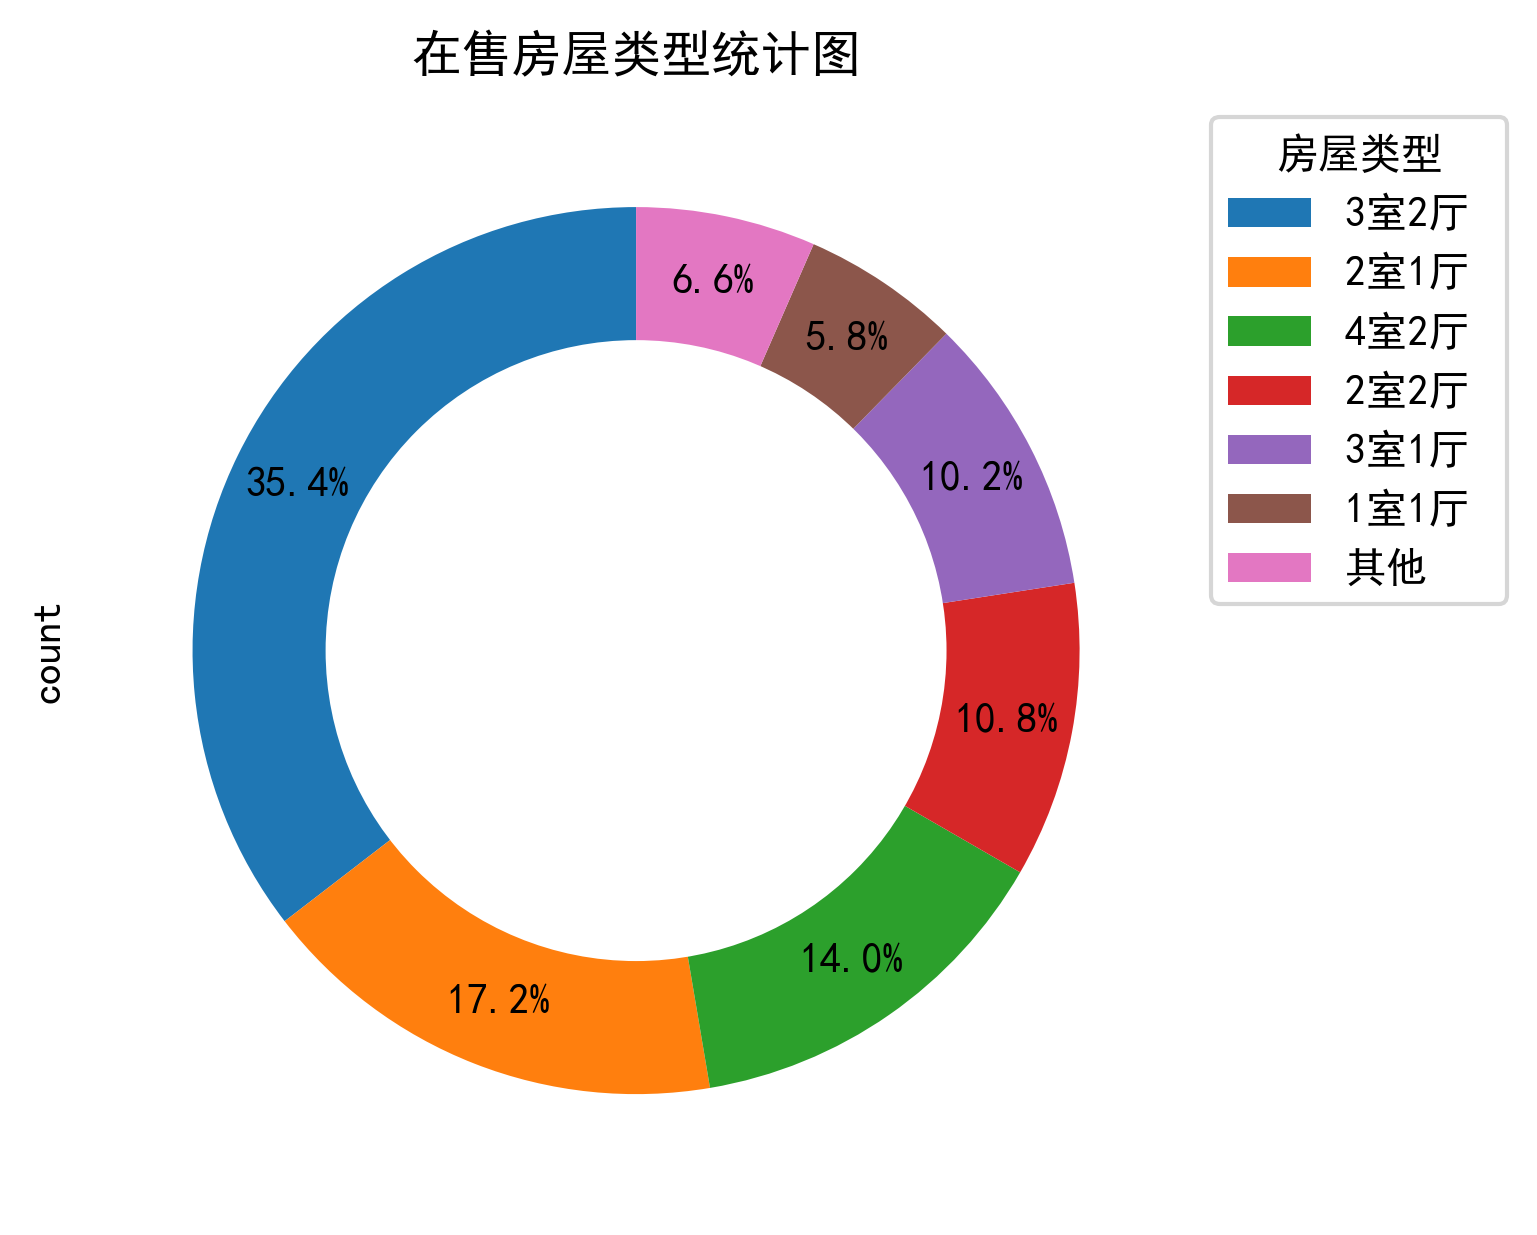

<Figure size 1920x1440 with 0 Axes>

In [63]:
# 创建数据库引擎
with app.app_context():
    engine = db.engine

with app.app_context():
    query = db.session.query(HouseInfo.house_type)
    sql = str(query.statement.compile(compile_kwargs={"literal_binds": True}))
    df = pd.read_sql(sql, engine)
    type_counts = df['house_type'].value_counts()

    # 合并占比低于 5% 的类别为“其他”
    total_count = type_counts.sum()
    small_categories = type_counts[type_counts / total_count < 0.05]
    type_counts = type_counts[type_counts / total_count >= 0.05]
    type_counts['其他'] = small_categories.sum()

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文乱码
    plt.rcParams['axes.unicode_minus'] = False

    # 绘制饼图，隐藏原标签
    type_counts.plot(
        kind='pie',
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85,
        labels=None
    )

    # 添加更新后的图例
    plt.legend(
        type_counts.index,
        title='房屋类型',
        bbox_to_anchor=(1, 1)
    )

    # 设置环形图
    centre_circle = Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title('在售房屋类型统计图')
    plt.show()
    plt.savefig('my_plot_high_res.png', dpi=600, format='png')

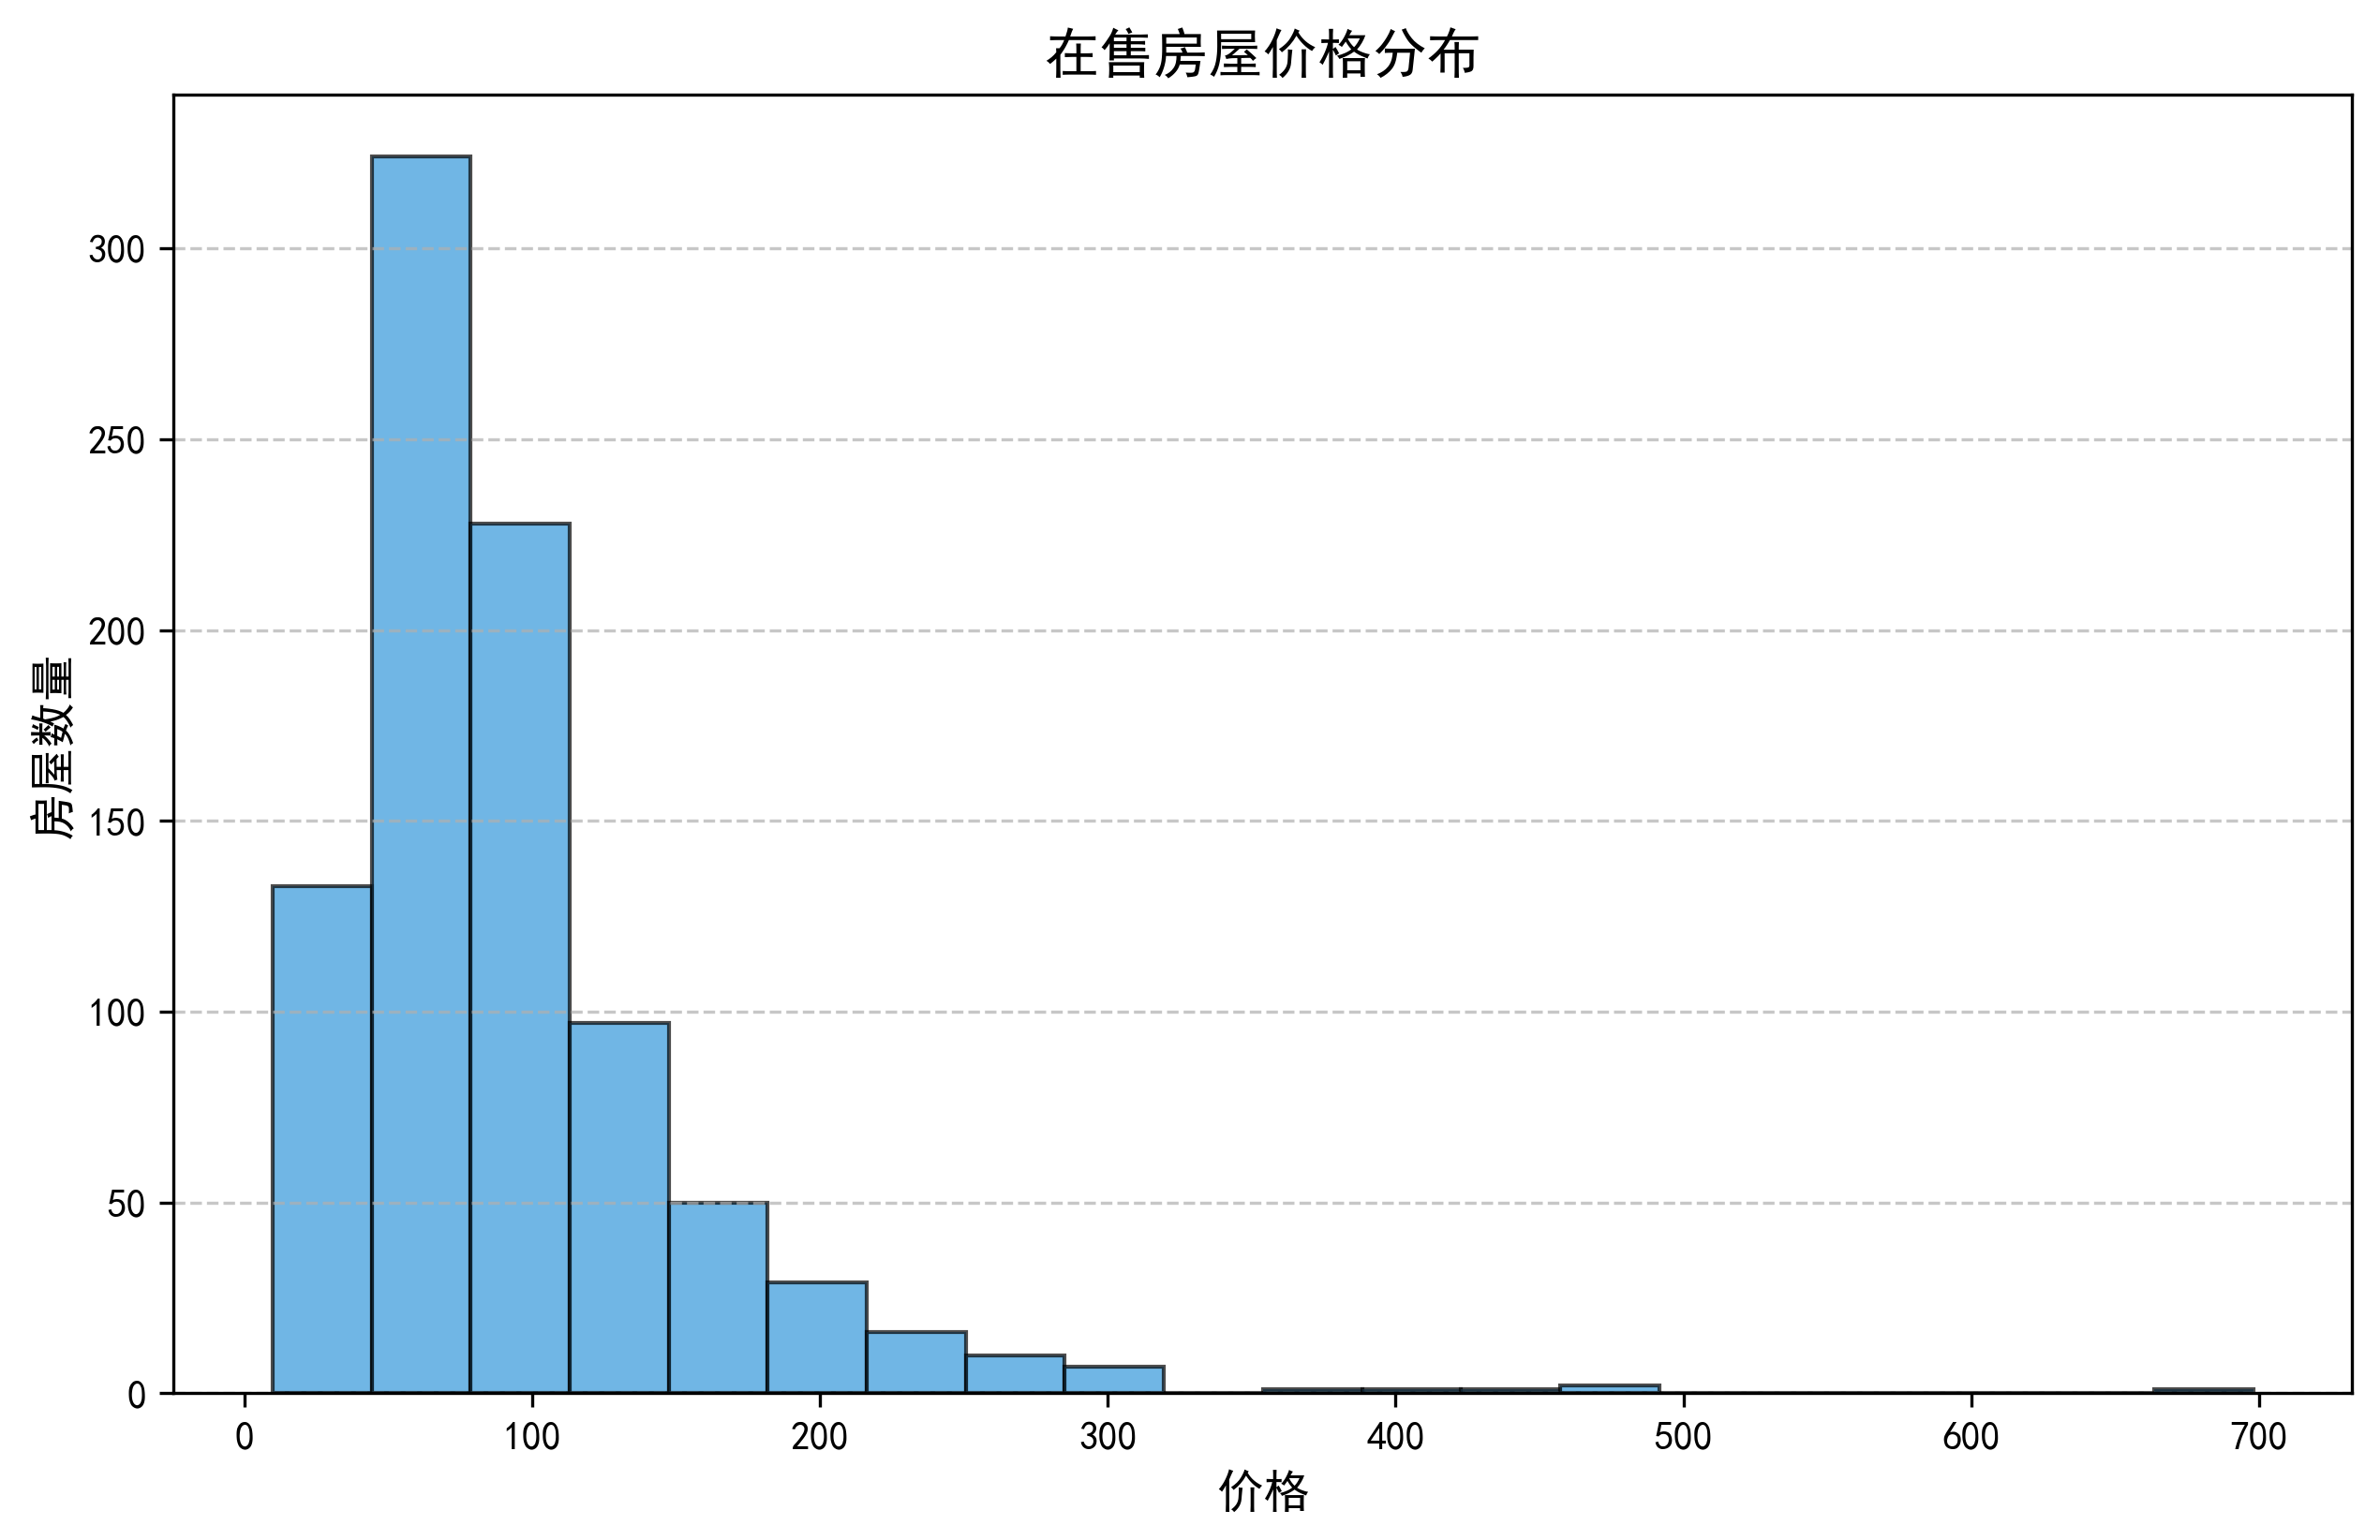

In [60]:
with app.app_context():
    # 查询所有房屋价格数据
    query = db.session.query(HouseInfo.price).all()
    prices = [price[0] for price in query]
    
    # 绘制直方图
    plt.figure(figsize=(10, 6))
    plt.hist(
        prices, 
        bins=20, 
        edgecolor='black', 
        alpha=0.7, 
        color='#3498db'
    )
    plt.title('在售房屋价格分布', fontsize=14)
    plt.xlabel('价格', fontsize=12)
    plt.ylabel('房屋数量', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.savefig('my_plot_high_res.png', dpi=600, format='png')
    plt.show()

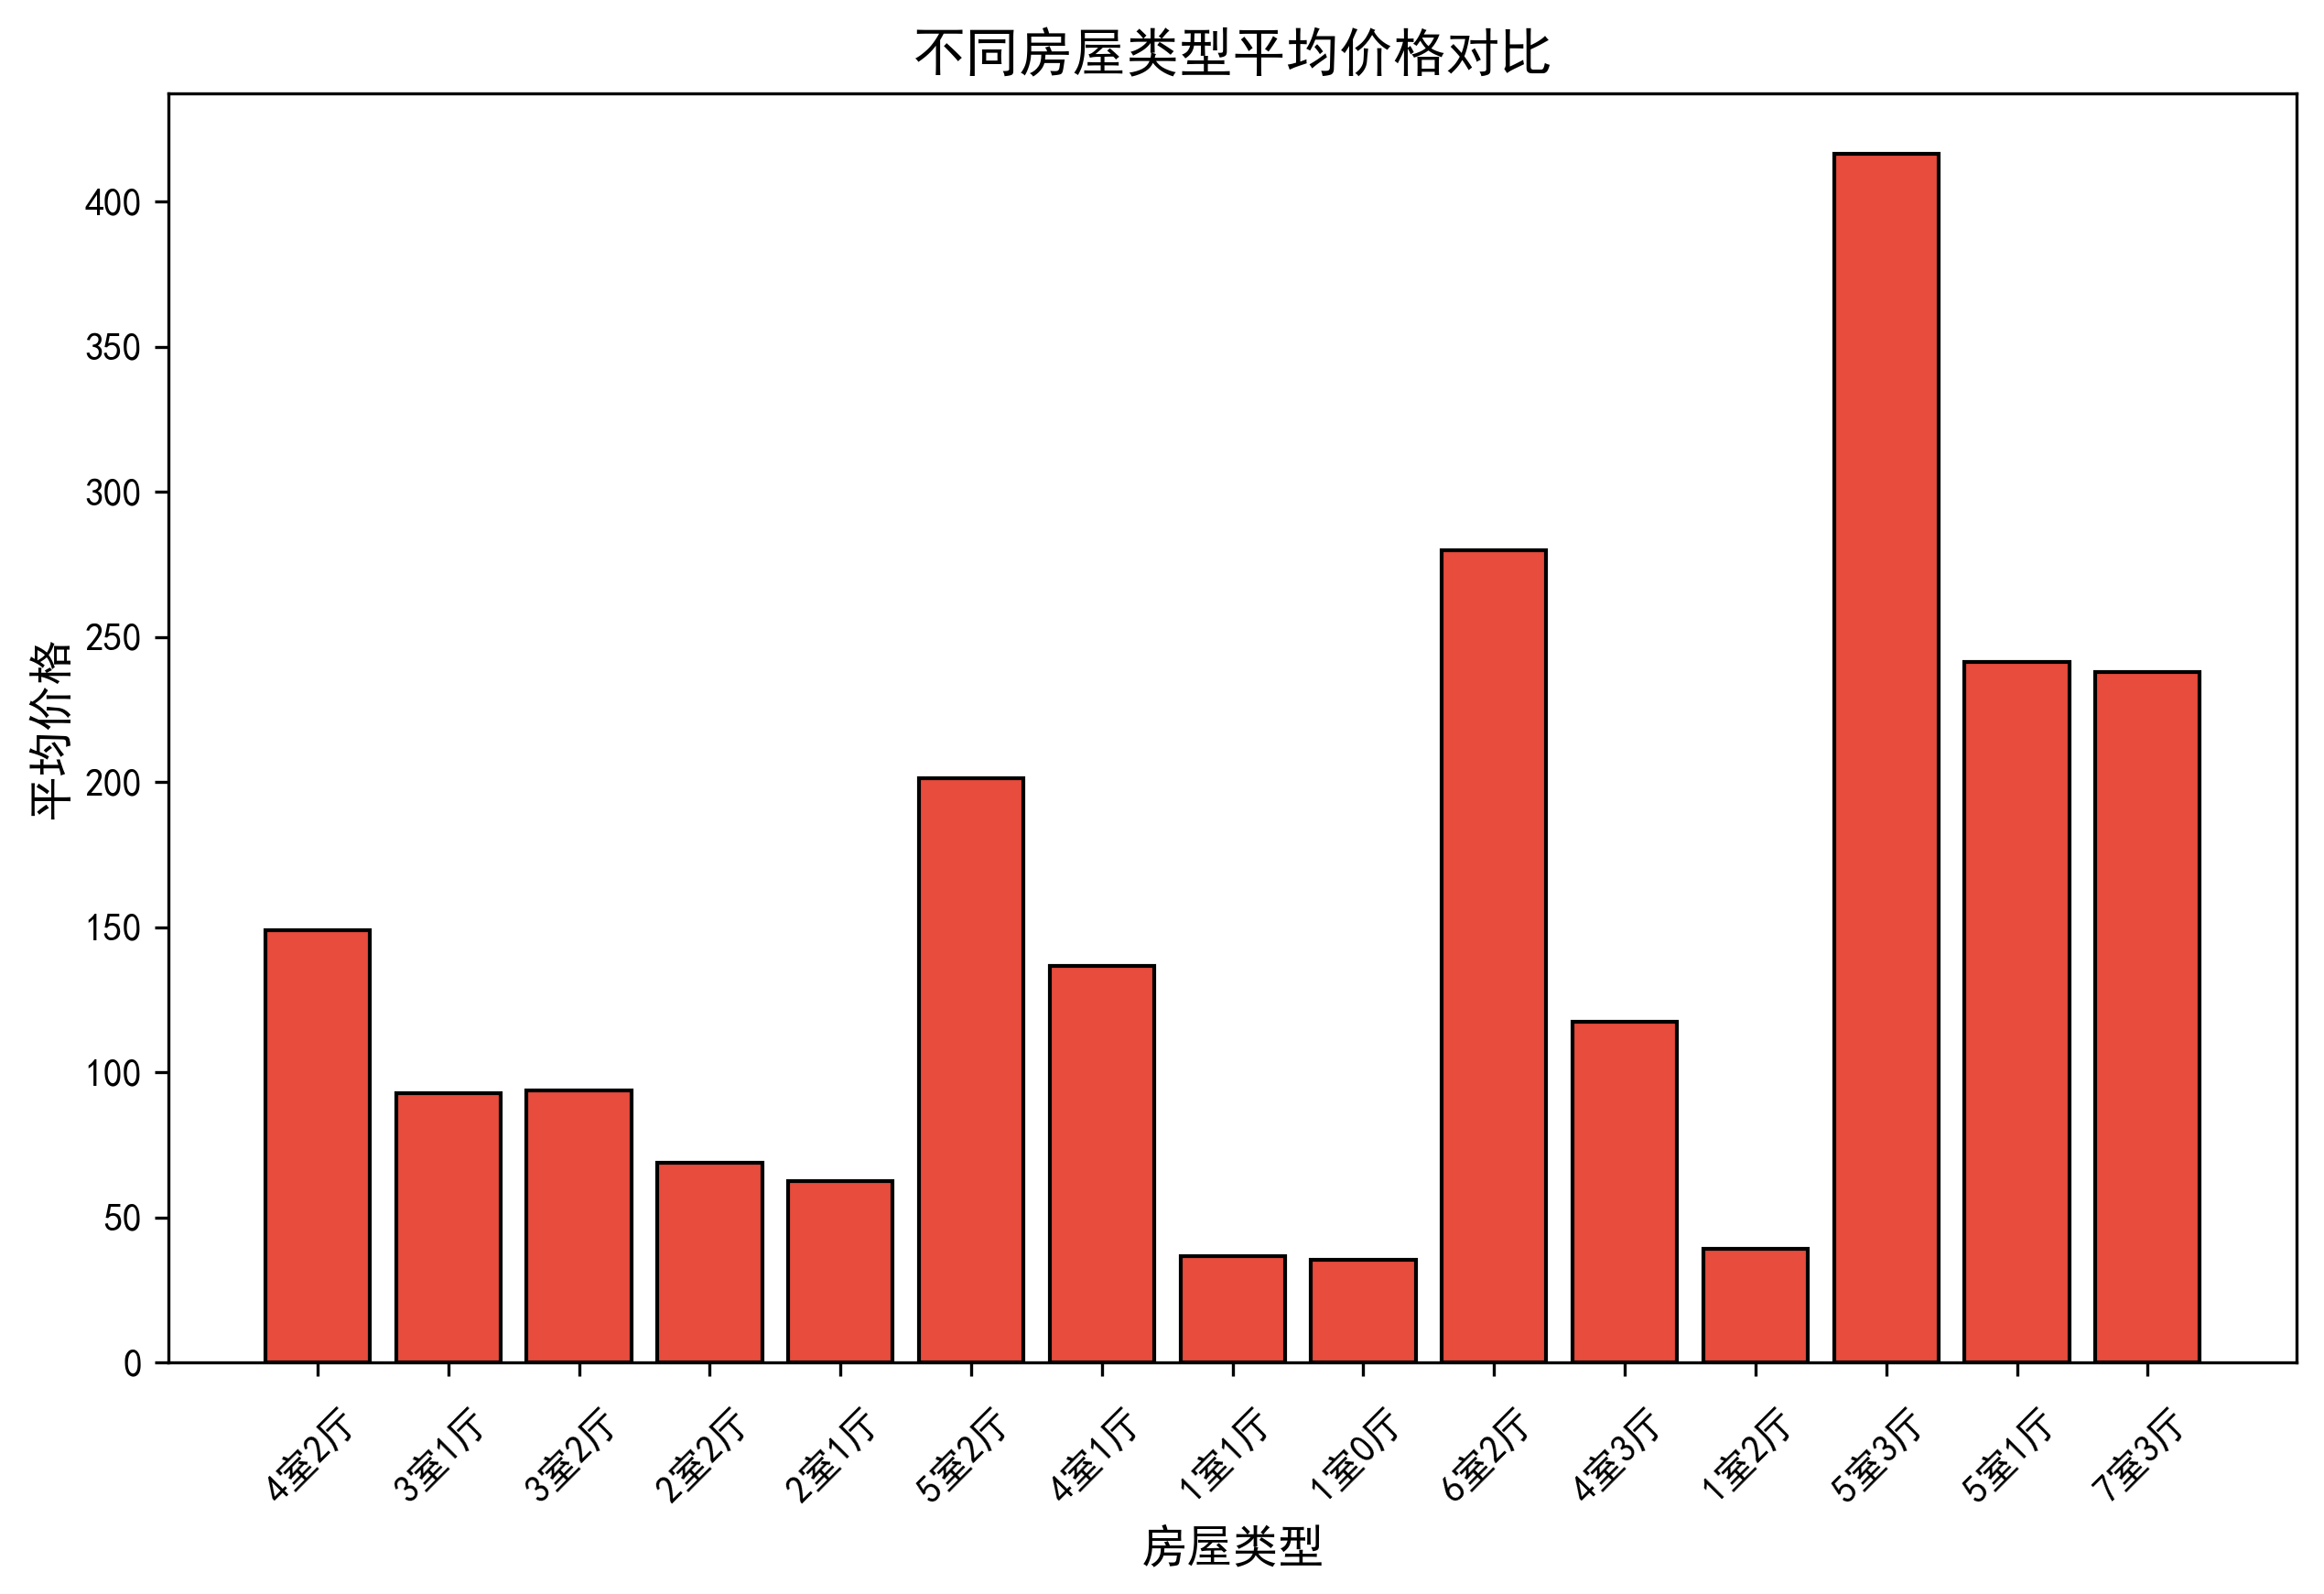

<Figure size 1920x1440 with 0 Axes>

In [62]:
with app.app_context():
    # 按房屋类型统计平均价格
    query = db.session.query(
        HouseInfo.house_type,
        func.avg(HouseInfo.price).label('avg_price')
    ).group_by(HouseInfo.house_type).all()
    df = pd.DataFrame(query, columns=['house_type', 'avg_price'])
    
    # 绘制柱状图
    plt.figure(figsize=(10, 6))
    plt.bar(
        df['house_type'], 
        df['avg_price'], 
        color='#e74c3c', 
        edgecolor='black'
    )
    plt.title('不同房屋类型平均价格对比', fontsize=14)
    plt.xlabel('房屋类型', fontsize=12)
    plt.ylabel('平均价格', fontsize=12)
    plt.xticks(rotation=45)
    
    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.show()
    plt.savefig('my_plot_high_res.png', dpi=600, format='png')

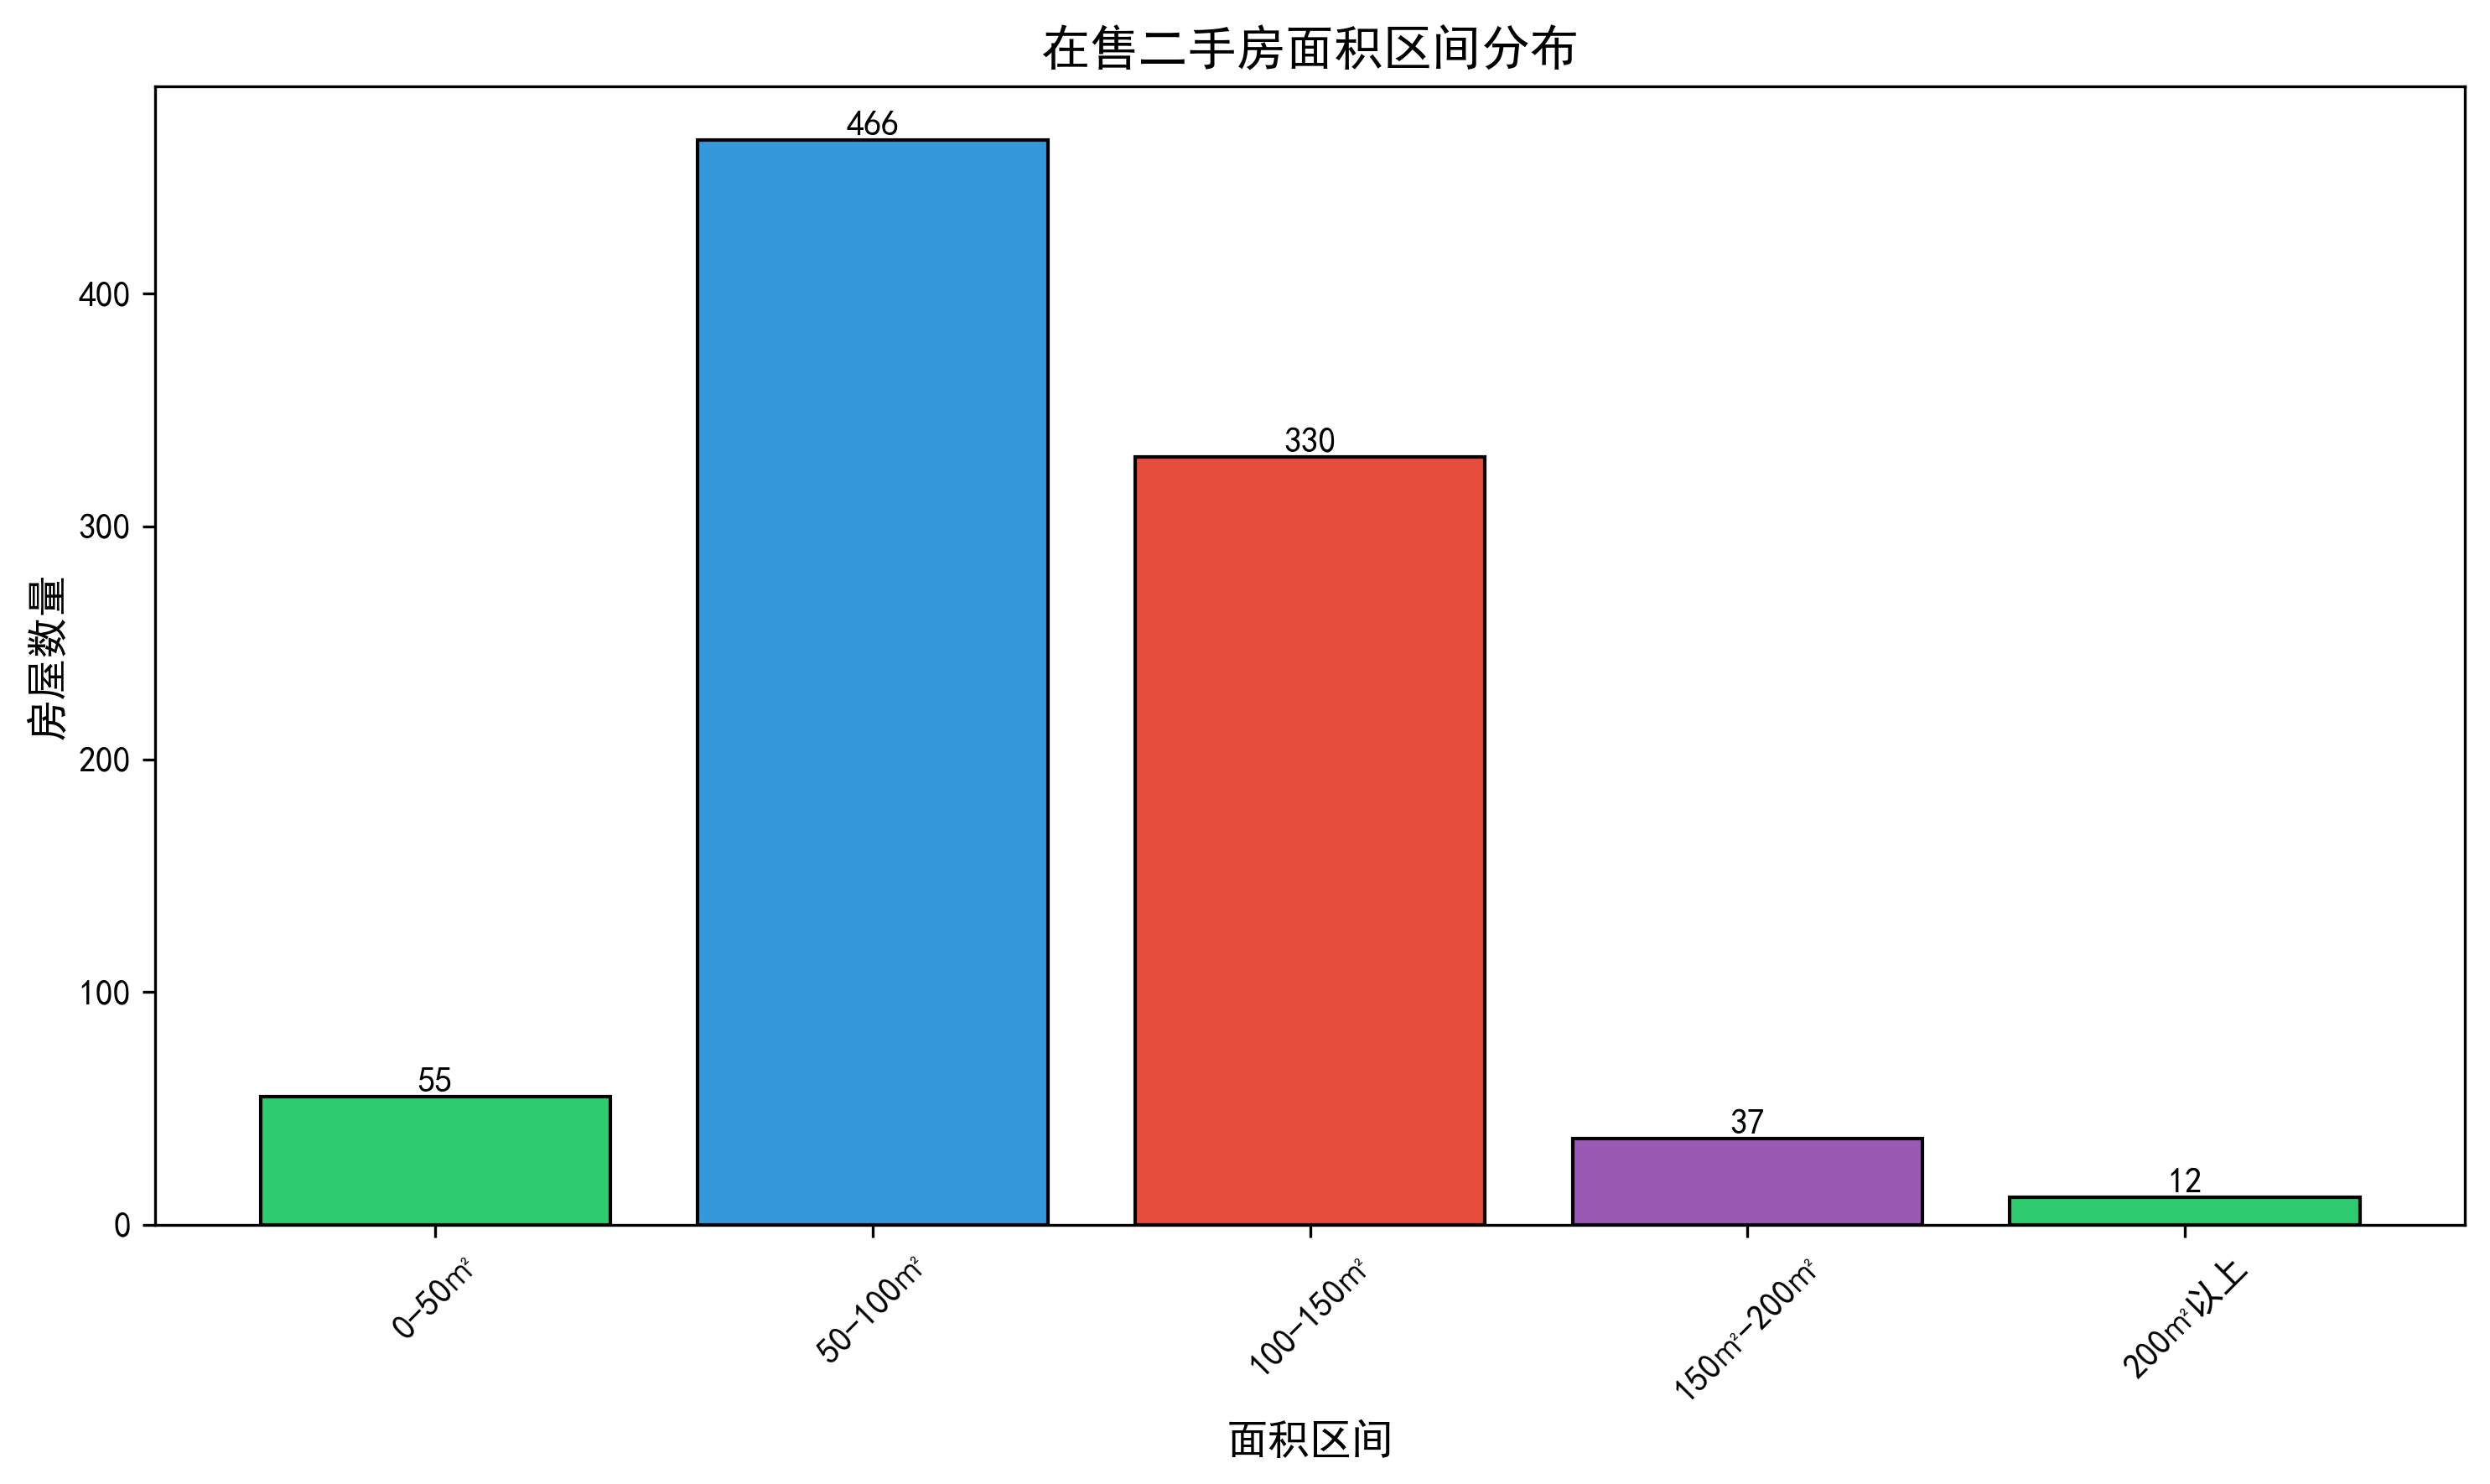

In [57]:
with app.app_context():
    # 定义面积区间和标签（关键：添加这两行）
    area_bins = [0, 50, 100, 150,200,float('inf')]
    area_labels = ['0-50㎡', '50-100㎡', '100-150㎡', '150㎡-200㎡' , '200㎡以上']
    # 查询所有面积数据并转换为DataFrame
    query = db.session.query(HouseInfo.house_area).all()
    df = pd.DataFrame(query, columns=['house_area'])
    
    # 过滤无效数据（面积需大于0）
    df = df[df['house_area'] > 0]
    
    # 划分面积区间
    df['area_bin'] = pd.cut(df['house_area'], bins=area_bins, labels=area_labels)
    
    # 统计各区间数量
    area_counts = df['area_bin'].value_counts().sort_index()
    
    # 绘制柱状图
    plt.figure(figsize=(10, 6))
    plt.bar(
        area_counts.index,
        area_counts.values,
        color=['#2ecc71', '#3498db', '#e74c3c', '#9b59b6'],
        edgecolor='black'
    )
    plt.title('在售二手房面积区间分布', fontsize=14)
    plt.xlabel('面积区间', fontsize=12)
    plt.ylabel('房屋数量', fontsize=12)
    plt.xticks(rotation=45)
    
    # 添加数值标签
    for i, count in enumerate(area_counts.values):
        plt.text(i, count, str(count), ha='center', va='bottom')
    
    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.tight_layout()
    plt.show()

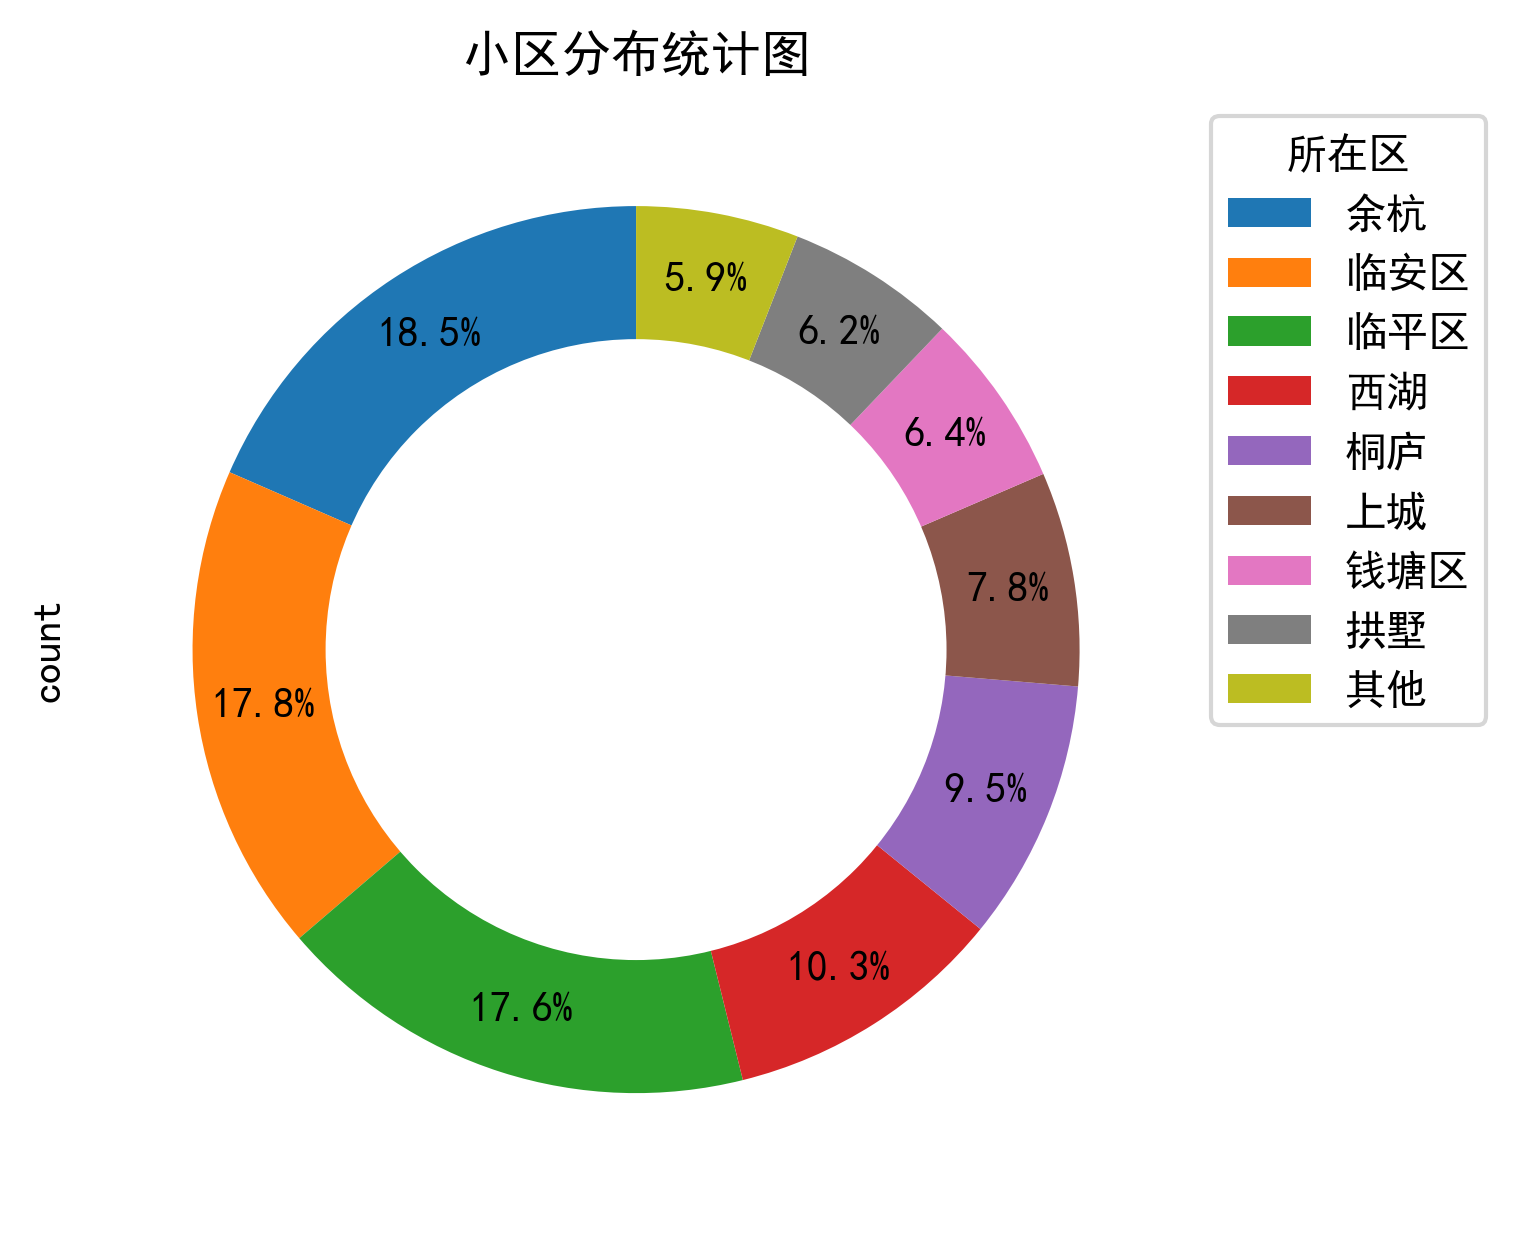

In [20]:
# 创建数据库引擎
with app.app_context():
    engine = db.engine

with app.app_context():
    query = db.session.query(EstateInfo.district)
    sql = str(query.statement.compile(compile_kwargs={"literal_binds": True}))
    df = pd.read_sql(sql, engine)
    type_counts = df['district'].value_counts()

    #合并占比低于 5% 的类别为“其他”
    total_count = type_counts.sum()
    small_categories = type_counts[type_counts / total_count < 0.05]
    type_counts = type_counts[type_counts / total_count >= 0.05]
    type_counts['其他'] = small_categories.sum()

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文乱码
    plt.rcParams['axes.unicode_minus'] = False

    # 绘制饼图，隐藏原标签
    type_counts.plot(
        kind='pie',
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85,
        labels=None
    )

    # 添加更新后的图例
    plt.legend(
        type_counts.index,
        title='所在区',
        bbox_to_anchor=(1, 1)
    )

    # 设置环形图
    centre_circle = Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title('小区分布统计图')
    plt.show()

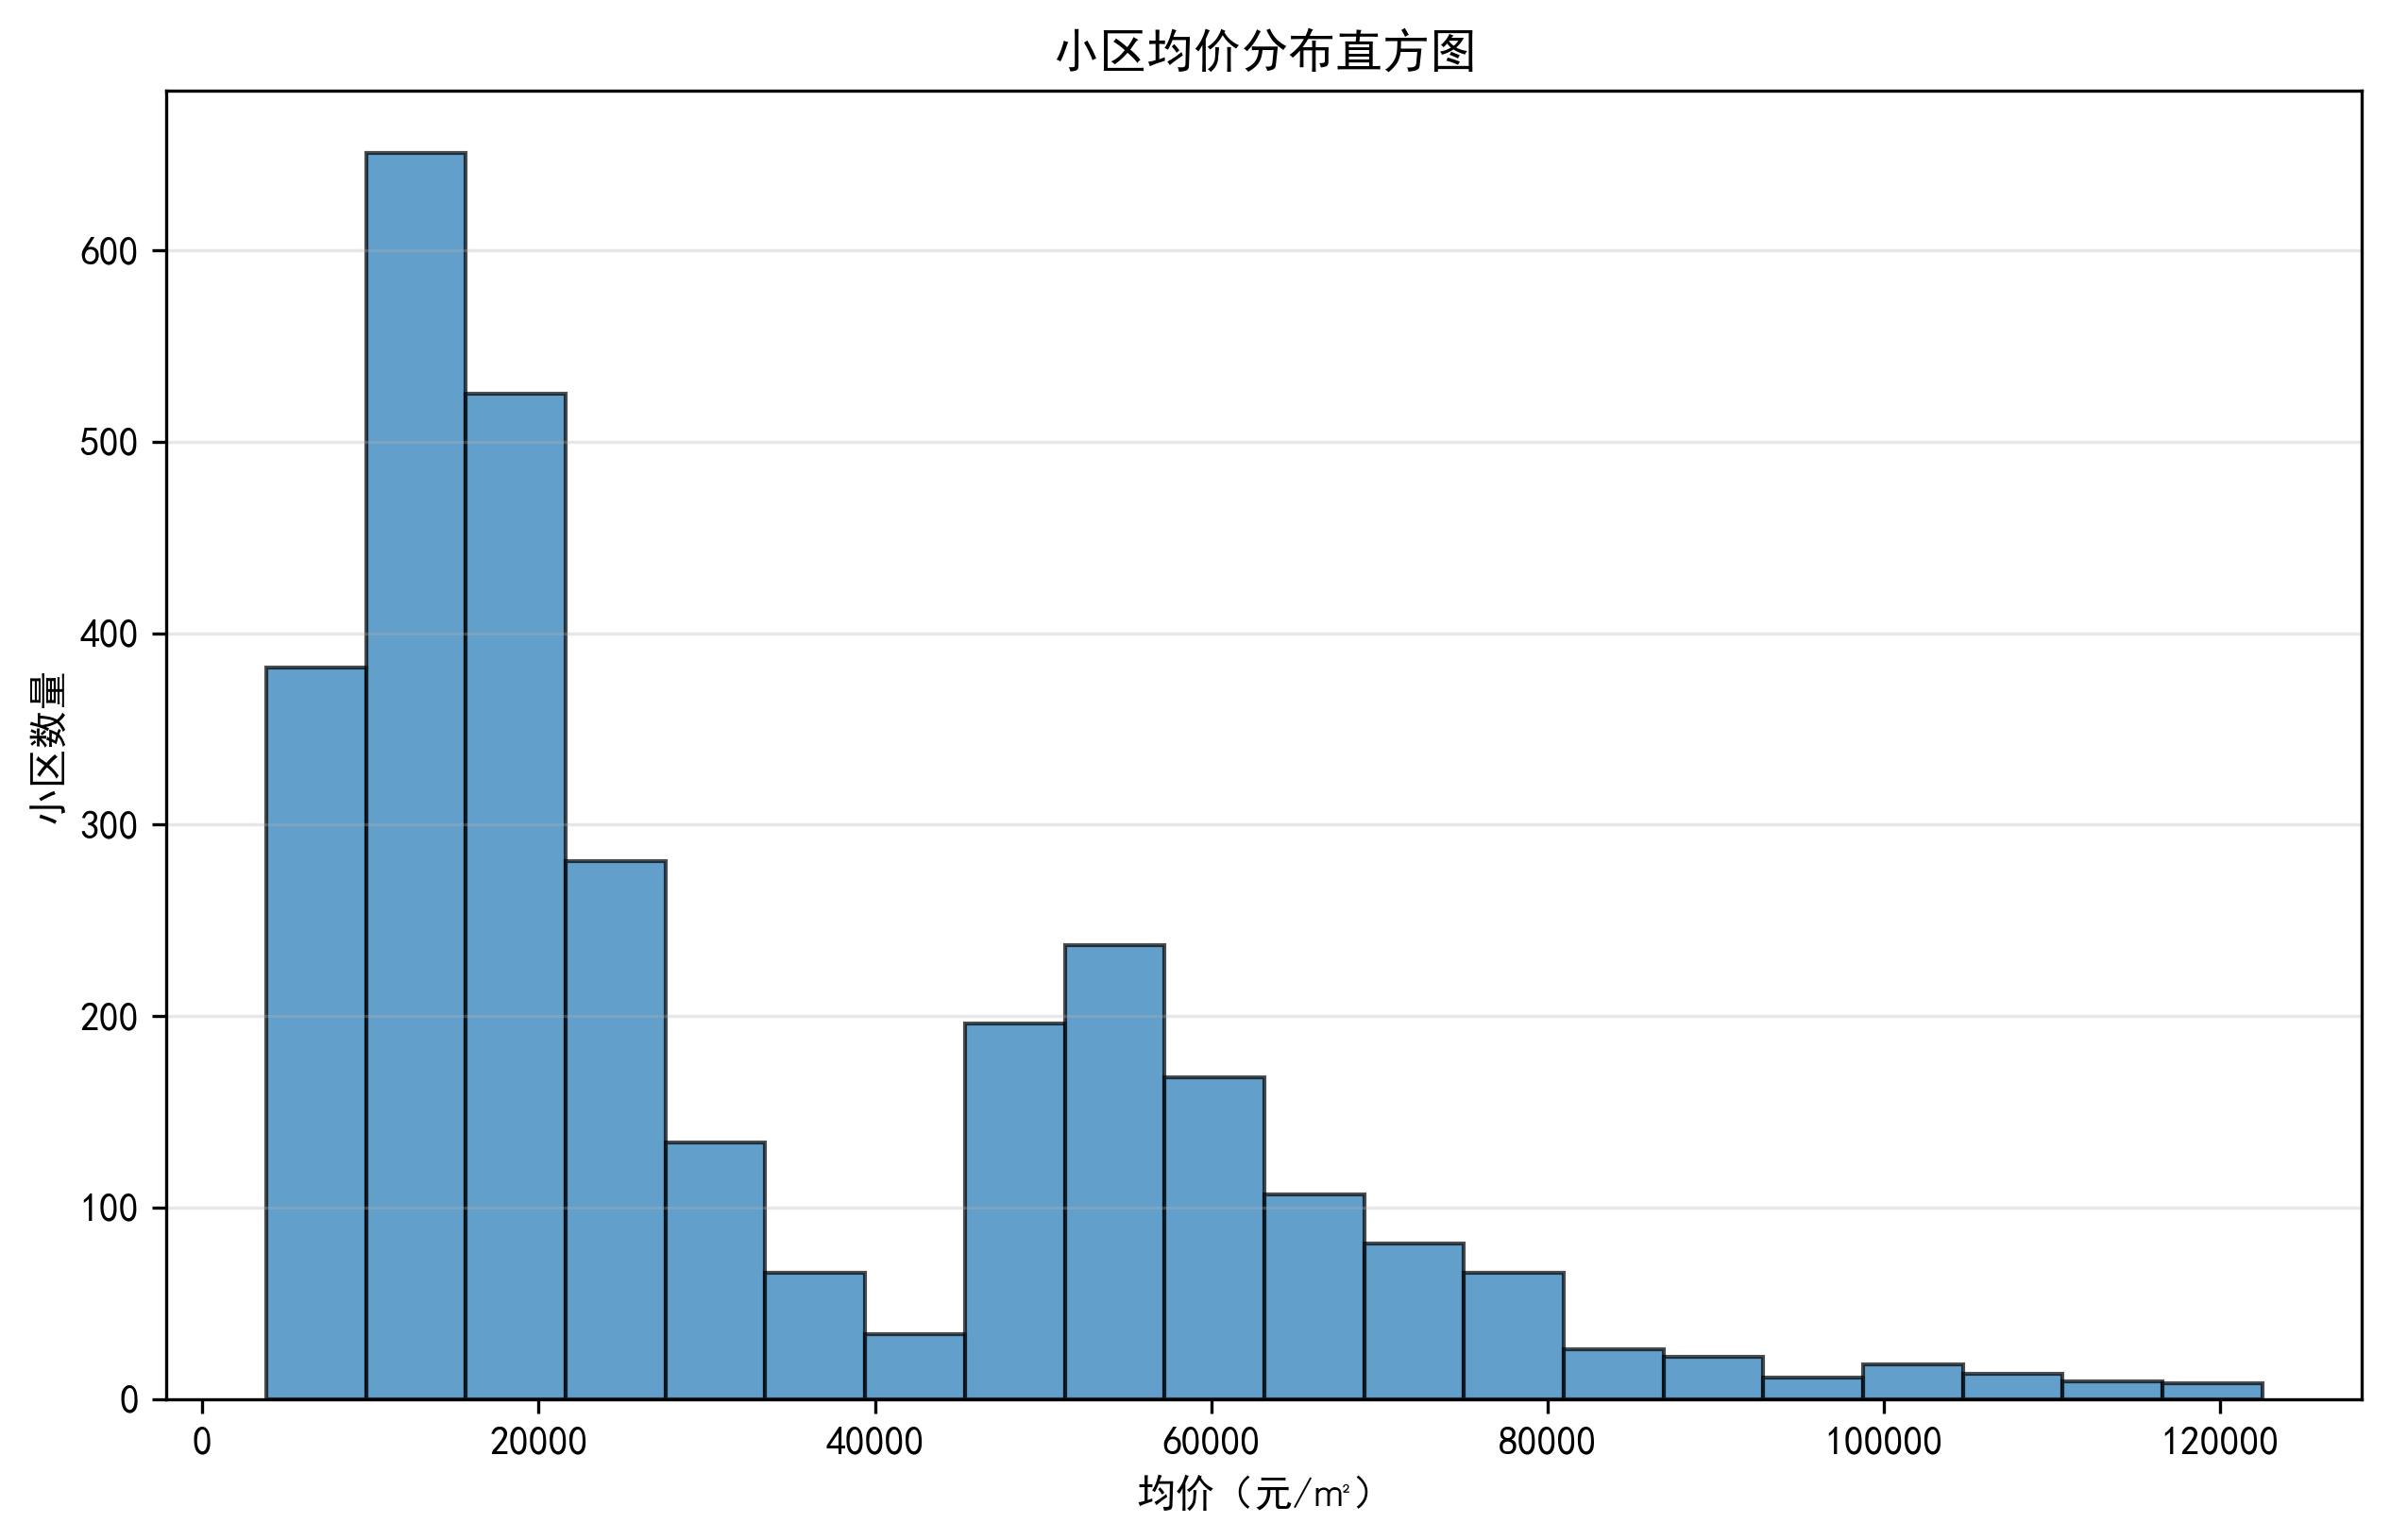

In [22]:
with app.app_context():
    # 查询所有小区均价数据
    query = db.session.query(EstateInfo.average_price).all()
    average_prices = [price[0] for price in query]

    # 绘制直方图
    plt.figure(figsize=(10, 6))
    plt.hist(average_prices, bins=20, edgecolor='black', alpha=0.7)
    plt.title('小区均价分布直方图')
    plt.xlabel('均价（元/㎡）')
    plt.ylabel('小区数量')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

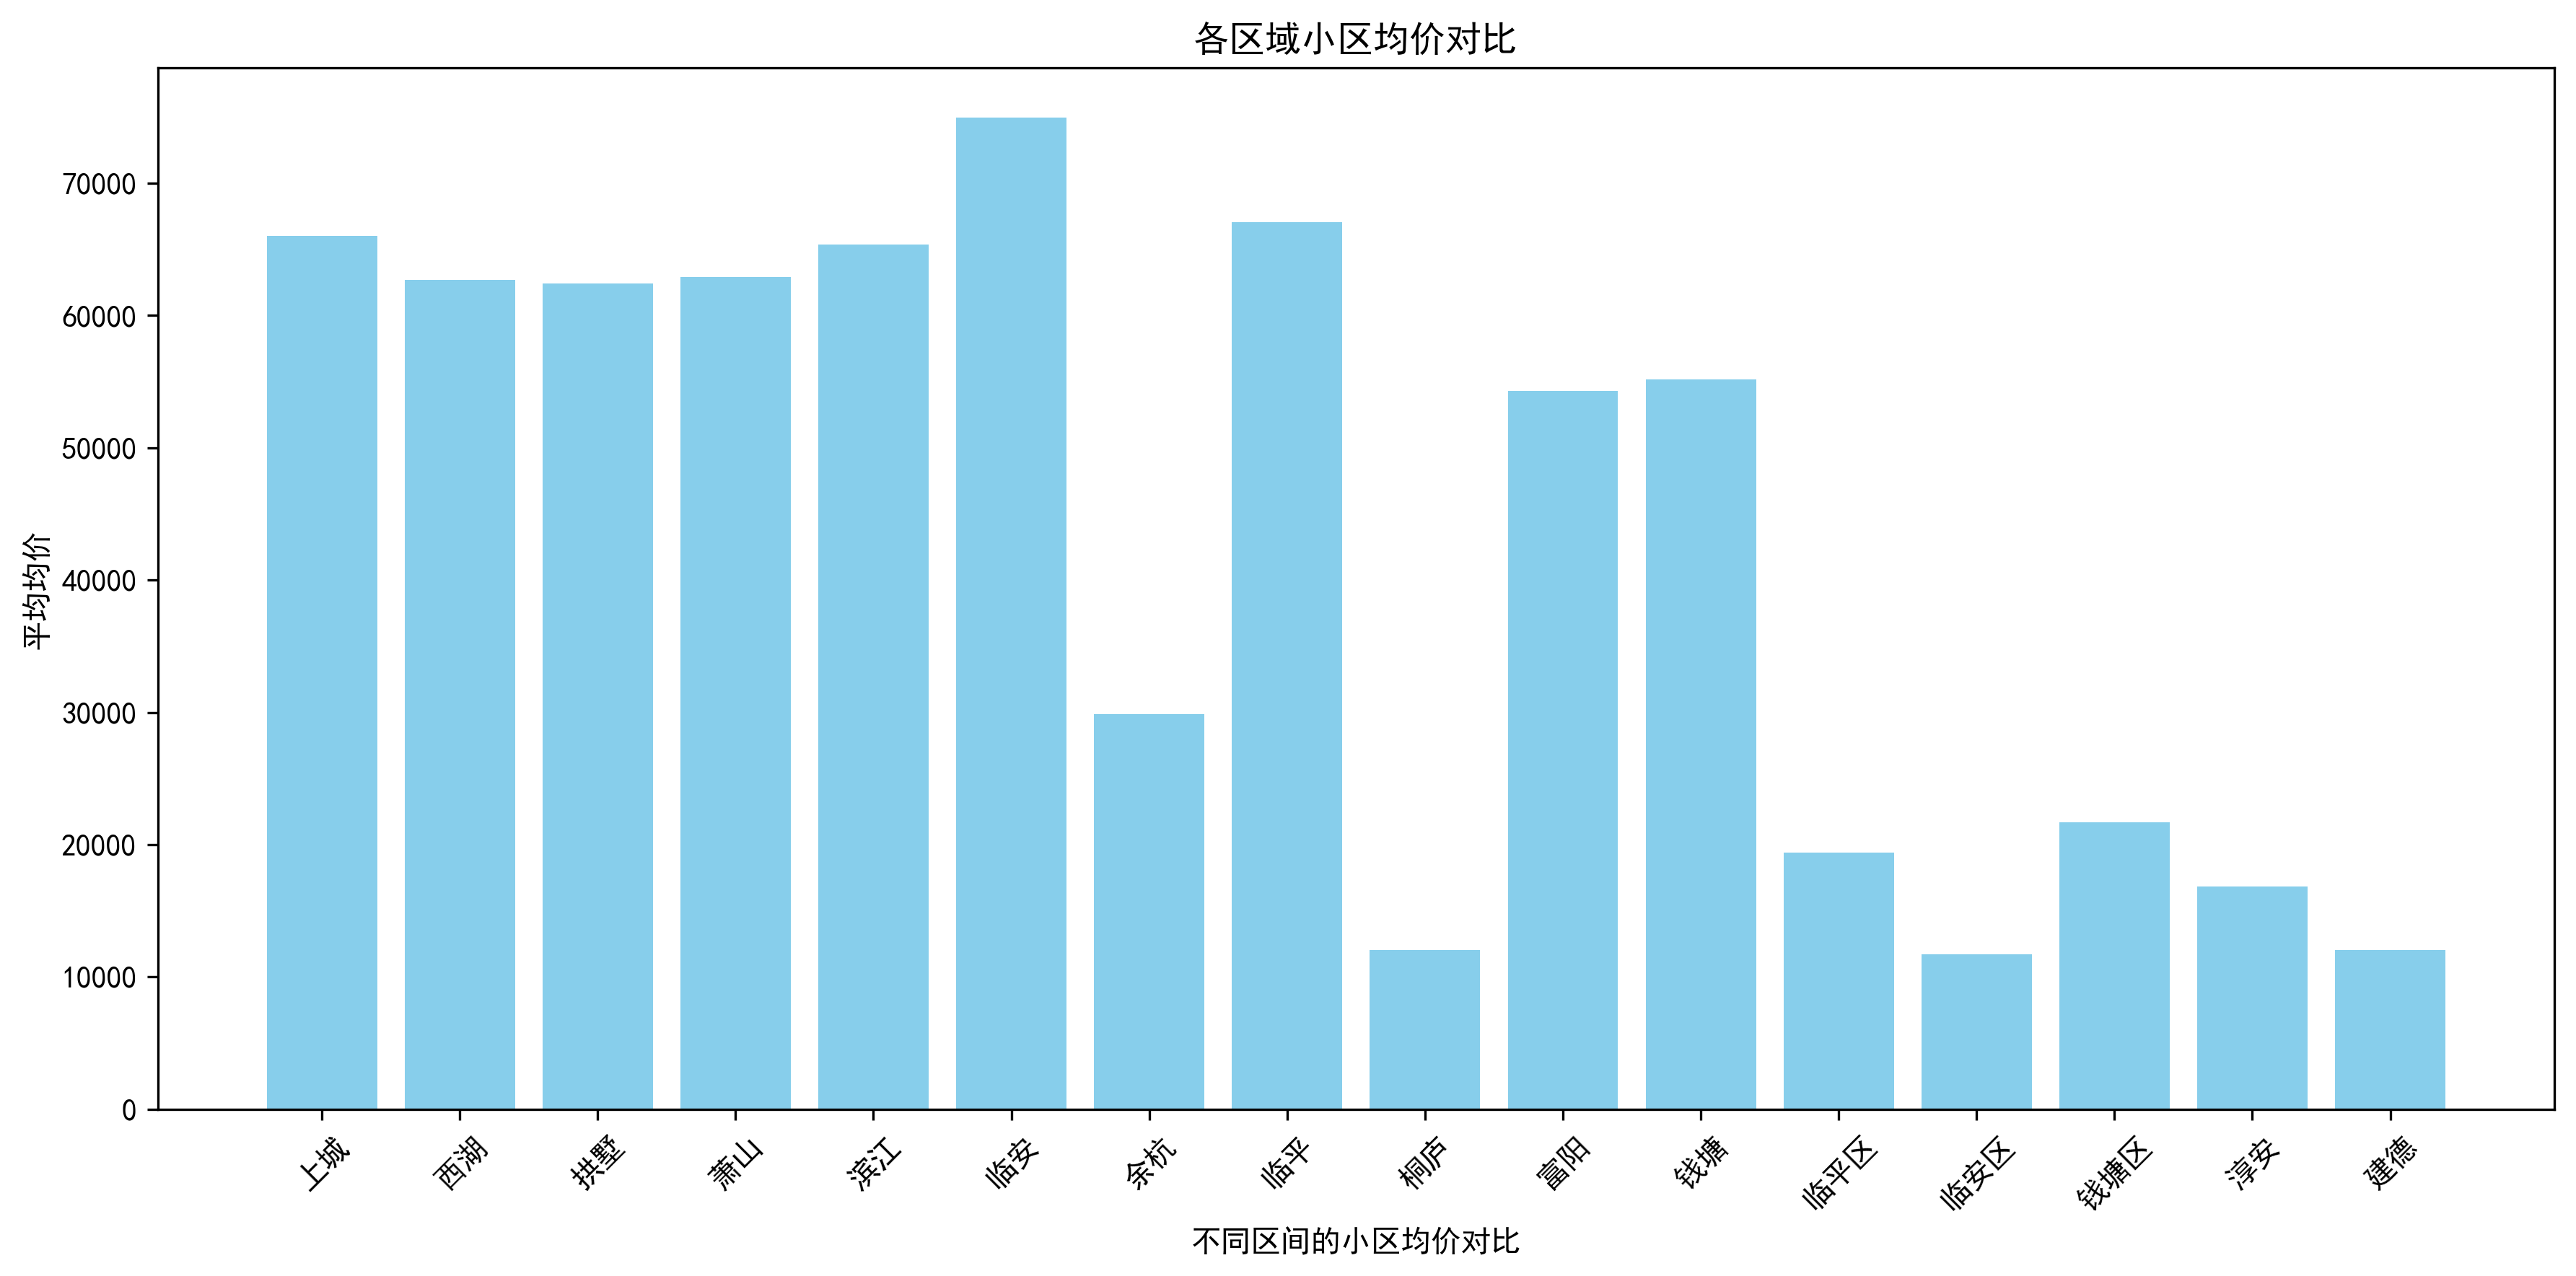

In [24]:
with app.app_context():
    # 查询各区域的平均均价
    query = db.session.query(
        EstateInfo.district,
        db.func.avg(EstateInfo.average_price)
    ).group_by(EstateInfo.district).all()
    district_avg_price = pd.DataFrame(query, columns=['district', 'average_price'])

    # 绘制柱状图
    plt.figure(figsize=(12, 6))
    plt.bar(district_avg_price['district'], district_avg_price['average_price'], color='skyblue')
    plt.title('各区域小区均价对比')
    plt.xlabel('不同区间的小区均价对比')
    plt.ylabel('平均均价')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

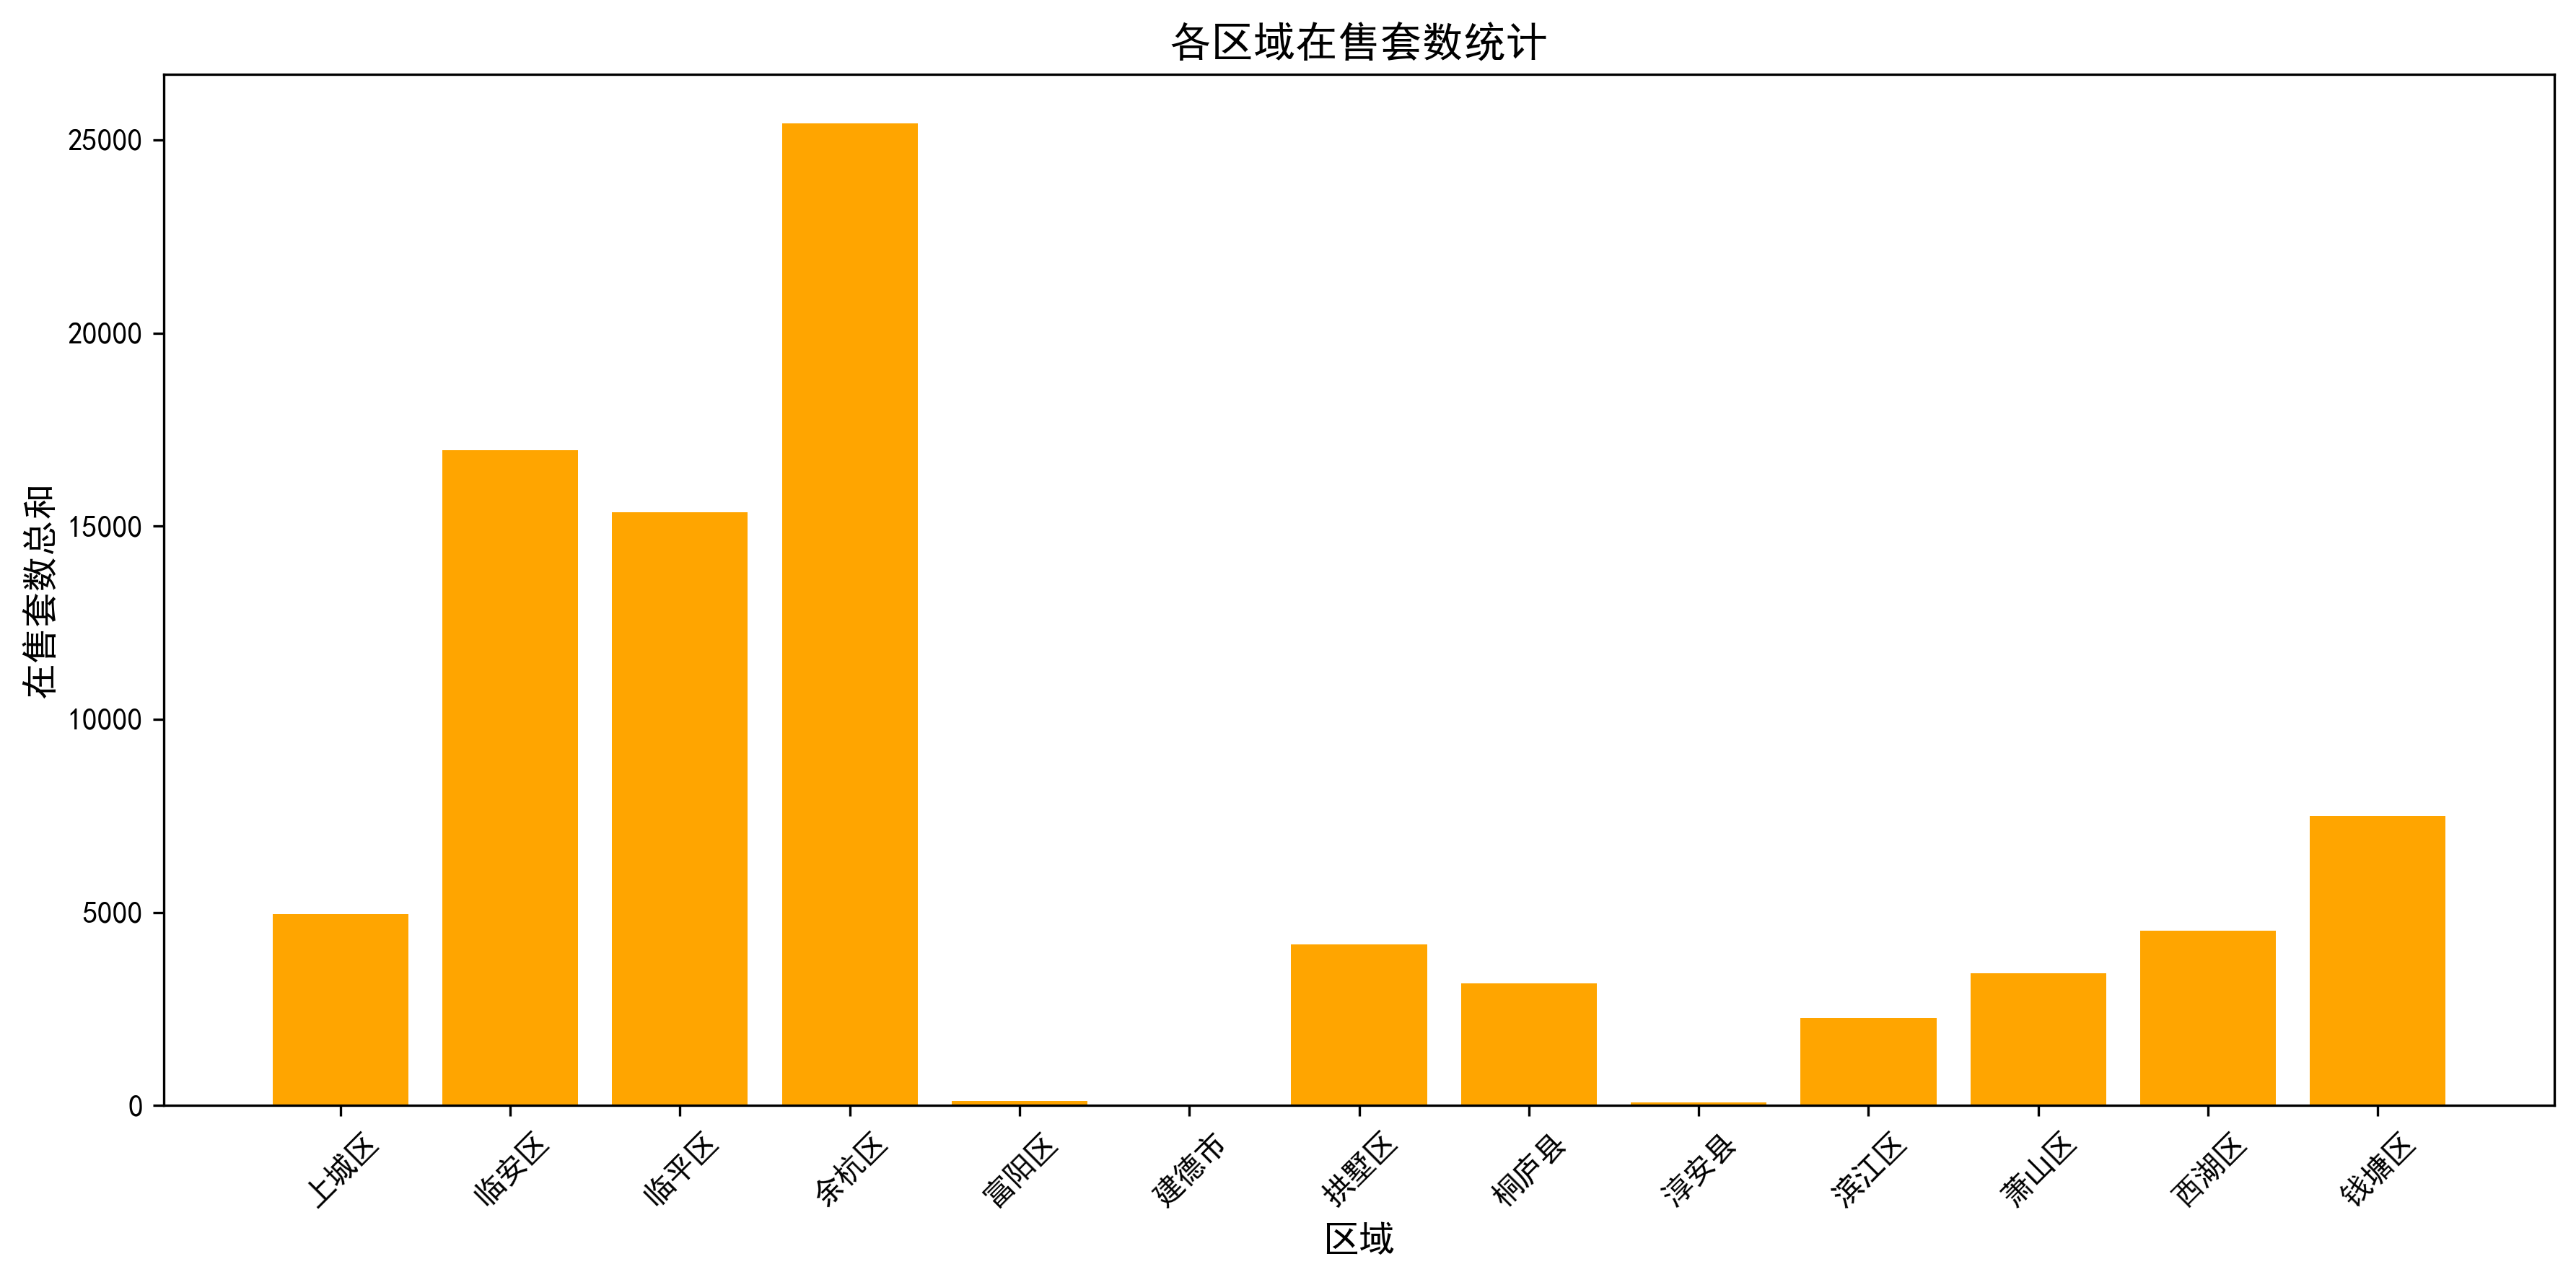

In [43]:
with app.app_context():
    db.create_all()  # 关键：创建数据库表
    # 区域名称映射
    district_mapping = {
        '上城': '上城区', '西湖': '西湖区', '拱墅': '拱墅区',
        '萧山': '萧山区', '滨江': '滨江区', '余杭': '余杭区',
        '临平': '临平区', '钱塘': '钱塘区', '富阳': '富阳区',
        '临安': '临安区', '桐庐': '桐庐县', '淳安': '淳安县', '建德': '建德市'
    }

    # 查询在售套数
    query = db.session.query(
        EstateInfo.district,
        db.func.sum(EstateInfo.listings).label('total_listings')
    ).group_by(EstateInfo.district).all()
    
    district_listings = pd.DataFrame(query, columns=['district', 'total_listings'])
    # 统一区域名称
    district_listings['district'] = district_listings['district'].apply(
        lambda x: district_mapping.get(x, x)
    )
    district_listings = district_listings.groupby('district', as_index=False)['total_listings'].sum()
    
    # 绘制柱状图
    plt.figure(figsize=(12, 6))
    plt.bar(district_listings['district'], district_listings['total_listings'], color='orange')
    plt.title('各区域在售套数统计', fontsize=14)
    plt.xlabel('区域', fontsize=12)
    plt.ylabel('在售套数总和', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()